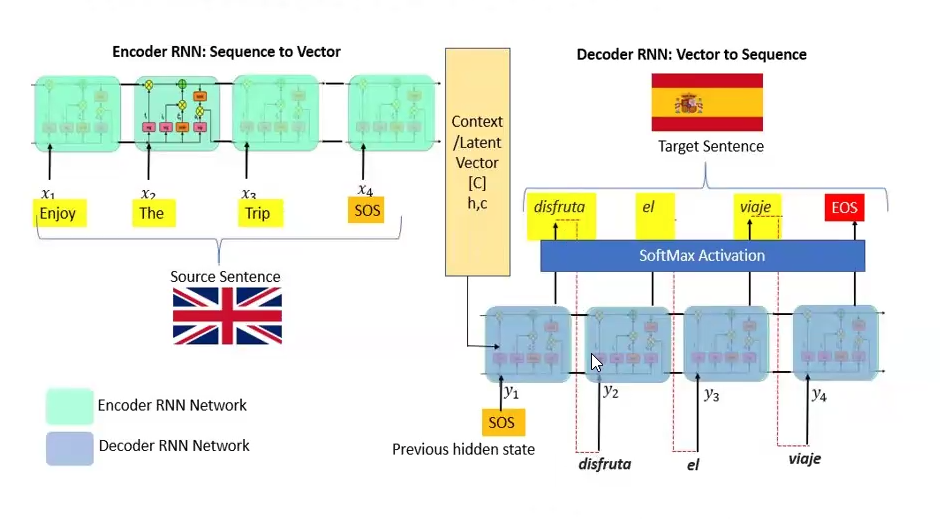

# Dataset loading and Preprocessing

In [1]:
import re, string
from nltk.stem.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

MAX_SEQUENCE_LENGTH = 64  # Maximum length of padded sequences

class Preprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer() # stemmer

    def apply_preprocessing(self, text):
        text = text.lower() # convert to lowercase
        text = self.remove_characters(text)
        text = remove_stopwords(text) # remove stopwords
        # text = self.stemming(text)
        text = self.truncate(text)
        text = self.add_os_tokens(text)
        return text
    
    def stemming(self, text):
        return " ".join([self.stemmer.stem(word) for word in text.split()])

    def remove_characters(self, text):
        emojis = r"[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+"  # regex for emojis
        html = r'http\S+|www\S+' # regex for urls
        mentions = r"@\w+" # regex for mentions
        hashtags = r"#" # regex for hashtags
        text = re.sub(f'{emojis}|{html}|{mentions}|{hashtags}','',text) # remove emojis, urls, mentions and hashtags
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
        return text


    def truncate(self, text):
        if len(text.split())>MAX_SEQUENCE_LENGTH:
            text = text[:MAX_SEQUENCE_LENGTH-2]
        return text

    def add_os_tokens(self, text): # os is of sentence
        text = '<sos> ' + text
        text += ' <eos>'
        return text

# Tokenization

In [19]:
from tokenizers import Tokenizer, models, decoders, trainers
from tokenizers.pre_tokenizers import Whitespace

from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

class CreateTokenizer:
    def __init__(self, total_samples, chunk_size, vocab_size = 30000, load = True):
        self.total_samples = total_samples
        self.chunk_size = chunk_size
        self.vocab_size = vocab_size
        
        if load:
            self.tokenizer_en = self.load_tokenizer("tokenizer_en.json")
            self.tokenizer_fr = self.load_tokenizer("tokenizer_fr.json")
            self.show_tokenizers()
        else:
            self.init_tokenizer()
            

    def init_tokenizer(self):
        # Initialize BPE trainers for English and French
        self.trainer_en = trainers.BpeTrainer(vocab_size=self.vocab_size, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
        self.trainer_fr = trainers.BpeTrainer(vocab_size=self.vocab_size, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
    
        # Initialize BPE tokenizers for English and French
        self.tokenizer_en = Tokenizer(models.BPE(vocab_size=self.vocab_size))
        self.tokenizer_fr = Tokenizer(models.BPE(vocab_size=self.vocab_size))

        # Add pre-tokenizers (e.g., split on whitespace)
        self.tokenizer_en.pre_tokenizer = Whitespace()
        self.tokenizer_fr.pre_tokenizer = Whitespace()

        # Add decoders (e.g., convert tokens back to strings)
        self.tokenizer_en.decoder = decoders.BPEDecoder()
        self.tokenizer_fr.decoder = decoders.BPEDecoder()
        
        self.tokenizer_en.save("tokenizer_en.json")
        self.tokenizer_fr.save("tokenizer_fr.json")
        
    def tokenize_sentences(self, batch, mode = "test"):
        # Extract English and French text columns
        en_texts = (batch[:, 0]) # English column
        fr_texts = (batch[:, 1]) # French column
        if mode == "train":
            self.tokenizer_en = self.load_tokenizer("tokenizer_en.json")
            self.tokenizer_fr = self.load_tokenizer("tokenizer_fr.json")
            
            self.tokenizer_en.train_from_iterator(en_texts, trainer=self.trainer_en)
            self.tokenizer_fr.train_from_iterator(fr_texts, trainer=self.trainer_fr)
            
            self.tokenizer_en.save("tokenizer_en.json")
            self.tokenizer_fr.save("tokenizer_fr.json")
            
        
        # Tokenize the texts
        sequences_en = [self.tokenizer_en.encode(text).ids for text in en_texts]
        sequences_fr = [self.tokenizer_fr.encode(text).ids for text in fr_texts]

        # Pad sequences
        padded_sequences_en = pad_sequences(sequences_en, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=self.tokenizer_en.token_to_id("<pad>"))
        padded_sequences_fr = pad_sequences(sequences_fr, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=self.tokenizer_fr.token_to_id("<pad>"))

        return padded_sequences_en, padded_sequences_fr
    
    def create_embeddings(tokenizer):
        # Load Pre-trained GloVe Embeddings
        embedding_index = {} # Dictionary to store word embeddings

        with open('/kaggle/input/glove-6b-100/glove.6B.100d.txt', encoding='utf8') as glove_file:
            for line in glove_file:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embedding_index[word] = vector
                
        # Initialize embedding matrix
        num_words = min(MAX_SEQUENCE_LENGTH, len(tokenizer.get_vocab())+1)
        embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

        # Populate embedding matrix
        for word, index in tokenizer.get_vocab().items():
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
                
    def show_tokenizers(self):
        print(f"Unique words in English vocabulary: {self.tokenizer_en.get_vocab_size()}")
        print(f"Unique words in French vocabulary: {self.tokenizer_fr.get_vocab_size()}")
    
    def load_tokenizer(self, filepath):
        # Train the tokenizers on data, if not already trained
        tokenizer = Tokenizer.from_file(filepath)
        return tokenizer


# Data generator

In [20]:
import pandas as pd
import tensorflow as tf

# Data set loader
class DataGenerator:
    def __init__(self, preprocessor, tokenizing, chunk_size, total_samples):
        self.preprocessor = preprocessor
        self.tokenizing = tokenizing
        self.chunk_size = chunk_size
        self.total_samples = total_samples
        
        
    def data_generator(self, validation_split=0.1, subset="train", tokenizer_mode = "train"):
        count = 0  # Counter to track number of yields
        
        for chunk in pd.read_csv("en-fr.csv", chunksize=self.chunk_size):
            if len(chunk) < self.chunk_size:
                break

            chunk.fillna("", inplace=True)
            chunk["en"] = chunk["en"].apply(self.preprocessor.apply_preprocessing)
            chunk["fr"] = chunk["fr"].apply(self.preprocessor.apply_preprocessing)
            batch = chunk.astype(str).to_numpy()
            padded_sequences_en, padded_sequences_fr = self.tokenizing.tokenize_sentences(batch, tokenizer_mode)
        
            decoder_input = padded_sequences_fr 

            decoder_target = np.pad(padded_sequences_fr[:, 1:], ((0, 0), (0, 1)), constant_values=0)
            # Split the chunk into training and validation
            num_samples = len(padded_sequences_en)
            num_val = int(num_samples * validation_split) # Number of validation samples
            
            if subset == "train":
                # Yield training data
                yield (
                    padded_sequences_en[:-num_val],  # Encoder input (training)
                    decoder_input[:-num_val]         # Decoder input (training)
                ), decoder_target[:-num_val]         # Decoder target (training)
                count += 1
                if count >= int(self.total_samples * (1 - validation_split)) // self.chunk_size:  # Stop after yielding n times
                    break
            elif subset == "val":
                # Yield validation data
                yield (
                    padded_sequences_en[-num_val:],  # Encoder input (validation)
                    decoder_input[-num_val:]         # Decoder input (validation)
                ), decoder_target[-num_val:]         # Decoder target (validation)
                count += 1
                if count >= int(self.total_samples * validation_split) // self.chunk_size:  # Stop after yielding n times
                    break

def test_dataset(train_dataset, val_dataset):
    for batch in train_dataset:
        print(f"Batch read successfully, with shape {batch[0][0].shape}")
        break
    for batch in val_dataset:
        print(f"Batch read successfully, with shape {batch[0][0].shape}")
        break

In [21]:
VOCAB_SIZE = 30000
TOTAL_SAMPLES = 200000
CHUNK_SIZE = 35

preprocessor = Preprocessor()
tokenizers = CreateTokenizer(TOTAL_SAMPLES, CHUNK_SIZE, vocab_size=VOCAB_SIZE, load=False)
data = DataGenerator(preprocessor, tokenizers, CHUNK_SIZE, TOTAL_SAMPLES)

# Create training dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data.data_generator(validation_split=0.1, subset="train", tokenizer_mode = "train"),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32),  # Encoder input
            tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32)   # Decoder input
        ),
        tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32)       # Decoder target
    )
).prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: data.data_generator(validation_split=0.1, subset="val", tokenizer_mode = "train"),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32),  # Encoder input
            tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32)   # Decoder input
        ),
        tf.TensorSpec(shape=(None, MAX_SEQUENCE_LENGTH), dtype=tf.int32)       # Decoder target
    )
).prefetch(tf.data.AUTOTUNE)

In [22]:
# Train tokenizers
from IPython.display import clear_output
for i, batch in enumerate(train_dataset):
    print(f"Processing batch {i+1}/{(TOTAL_SAMPLES*0.9)//CHUNK_SIZE}")
    tokenizers.show_tokenizers()
    clear_output(wait=True)
print()
for i, batch in enumerate(val_dataset):
    print(f"Processing batch {i+1}/{(TOTAL_SAMPLES*0.1)//CHUNK_SIZE}")
    tokenizers.show_tokenizers()
    clear_output(wait=True)
print()
tokenizers.show_tokenizers()

KeyboardInterrupt: 

# Model Architecture

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
EMBEDDING_DIM = 100

class Seq2SeqModel:
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, latent_dim, max_sequence_length):
        self.input_vocab_size = input_vocab_size # maximum number of unique words in input
        self.output_vocab_size = output_vocab_size # maximum number of unique words in output
        self.embedding_dim = embedding_dim # dimension of word embeddings
        self.latent_dim = latent_dim # dimension of latent space
        self.max_sequence_length = max_sequence_length # maximum length of input and output sequences

        # Build models
        self.encoder = self.build_encoder()
        self.decoder_training = self.build_decoder_training()
        self.model = self.build_model()
        
    def build_encoder(self):
        # Define the encoder
        encoder_inputs = Input(shape=(None,), name="encoder_input") # input sequence
        encoder_embedding = Embedding(input_dim=self.input_vocab_size, # input vocabulary
                                      output_dim=self.embedding_dim,  # dimension of word embeddings
                                      mask_zero=True # Ignore Padding Tokens
                                    )(encoder_inputs) # mask padding
        encoder_outputs, state_h, state_c= LSTM(self.latent_dim, 
                                                dtype='float32',
                                                return_state=True, # To return states
                                                name="encoder_lstm")(encoder_embedding) # LSTM cells

        encoder_model = Model(encoder_inputs, [ state_h, state_c], name="encoder") # Model for encoder
        return encoder_model
    
    def build_decoder_training(self):
        
        decoder_inputs = Input(shape=(None,), name="decoder_input") # input sequence from french
        encoder_state_h = Input(shape=(self.latent_dim,), name="decoder_state_h") # hidden long term memory state from encoder
        encoder_state_c = Input(shape=(self.latent_dim,), name="decoder_state_c") # hidden short term memor state from encoder

        decoder_embedding = Embedding(input_dim=self.output_vocab_size, 
                                      output_dim=self.embedding_dim, 
                                      mask_zero=True # Ignore Padding Tokens
                                    )(decoder_inputs) # word embeddings
        
        decoder_outputs= LSTM(self.latent_dim, 
                              return_sequences=True, 
                              name="decoder_lstm", 
                              dtype='float32',)\
            (decoder_embedding, initial_state=[encoder_state_h, encoder_state_c]) # LSTM cells

        decoder_dense = Dense(self.output_vocab_size, activation='softmax')(decoder_outputs) # output layer

        decoder_model = Model([decoder_inputs, encoder_state_h, encoder_state_c], 
                              decoder_dense, name="decoder") # Model for decoder
        return decoder_model
    
    def build_decoder_inference(self):
        decoder_inputs = Input(shape=(None,), name="decoder_input") # input sequence from french
        decoder_state_input_h = Input(shape=(self.latent_dim,), name="decoder_state_h") # previous hidden long term memory state
        decoder_state_input_c = Input(shape=(self.latent_dim,), name="decoder_state_c") # previous hidden short term memory state
        
        decoder_embedding = Embedding(input_dim=self.output_vocab_size, 
                                      output_dim=self.embedding_dim, 
                                      mask_zero=True # Ignore Padding Tokens
                                    )(decoder_inputs) # word embeddings
        
        decoder_outputs, state_h, state_c = LSTM(self.latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")\
            (decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]) # LSTM cells

        decoder_dense = Dense(self.output_vocab_size, activation='softmax')(decoder_outputs) # output layer

        decoder_model = Model([decoder_inputs, decoder_state_input_h, decoder_state_input_c], 
                              [decoder_dense, state_h, state_c], 
                              name="decoder") # Model for decoder
        return decoder_model
    
    def build_model(self):
        
        encoder_inputs = self.encoder.input  # Extract encoder input
        state_h, state_c = self.encoder.output  # Extract encoder states
        
        decoder_inputs = self.decoder_training.input[0]  # Extract decoder input
        decoder_outputs = self.decoder_training([decoder_inputs, state_h, state_c])  # Pass encoder states to decoder

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq_model") # Create model
        return model
        
    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train(self, dataset, epochs=10, validation_dataset=None, callbacks=None, batch_size=1):

        self.model.fit(
            dataset,
            epochs=epochs,
            validation_data=validation_dataset,
            callbacks=callbacks,
            batch_size=batch_size,
            verbose=1
        )

        
    def infer(self, input_sequence, start_token, end_token, preprocess, tokenizer_en, tokenizer_fr,max_length=10):
        input_sequence = preprocess(input_sequence)
        # Tokenize and pad the input sequence
        input_sequence = tokenizer_en.encode(input_sequence).ids
        input_sequence = pad_sequences([input_sequence], maxlen=self.max_sequence_length, padding='pre', value=tokenizer_en.token_to_id("<pad>"))
        
        
        # Build the inference decoder if not already built
        if not hasattr(self, 'decoder_inference'):
            self.decoder_inference = self.build_decoder_inference()
        
        # Encode the input sequence
        states_value = self.encoder.predict(input_sequence)  # Encode input
        
        # Initialize the target sequence with the start token
        target_seq = tf.constant([[start_token]])  # Start with the start token
        generated_sequence = []

        for _ in range(max_length):
            # Predict the next token
            decoder_outputs, h, c = self.decoder_inference([target_seq] + states_value)
            predicted_token = tf.argmax(decoder_outputs, axis=-1).numpy()[0, 0]  # Extract int

            # Append the predicted token to the generated sequence
            generated_sequence.append(predicted_token)
            
            # Stop if the end token is predicted
            if predicted_token == end_token:  # Stop on EOS token
                break
            
            # Update the target sequence and states
            target_seq = tf.constant([[predicted_token]])  # Feed back into decoder
            states_value = [h, c]  # Update states

        # Decode the generated sequence back into a string
        generated_text = tokenizer_fr.decode(generated_sequence)
        
        return generated_text

# Callbacks

In [46]:
# callbakcs
# Save best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="seq2seq_model.h5",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
)
# Learning rate scheduler
learning_rate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6
)
# tdqm keras
from tqdm.keras import TqdmCallback

In [47]:
# Define hyperparameters
input_vocab_size = tokenizers.tokenizer_en.get_vocab_size()
output_vocab_size = tokenizers.tokenizer_fr.get_vocab_size()
latent_dim = 512

# Initialize model
seq2seq = Seq2SeqModel(input_vocab_size, output_vocab_size, EMBEDDING_DIM, latent_dim, MAX_SEQUENCE_LENGTH)
seq2seq.model.summary(expand_nested=True)

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1000000     ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, None)]       0           []                               
                                                                                                  
 encoder_lstm (LSTM)            [(None, 512),        1255424     ['embedding[0][0]']              
                                 (None, 512),                                         

In [19]:
for batch in train_dataset.take(1):
    (encoder_input, decoder_input), decoder_target = batch
    print("Encoder input shape:", encoder_input.shape)
    print("Decoder input shape:", decoder_input.shape)
    print("Decoder target shape:", decoder_target.shape)
    print("Decoder target dtype:", decoder_target.dtype)
    print("Output shape:", seq2seq.model.predict([encoder_input[:5], decoder_input[:5]]).shape)

Encoder input shape: (23, 64)
Decoder input shape: (23, 64)
Decoder target shape: (23, 64)
Decoder target dtype: <dtype: 'int32'>
1/1 [==============================] - 2s 2s/step
Output shape: (5, 64, 10000)


In [20]:
tdqm_callback = TqdmCallback()
# Compile model
seq2seq.compile()

# Train model
seq2seq.train(dataset=train_dataset, validation_dataset=val_dataset, epochs=10,
              callbacks=[checkpoint_callback, learning_rate_scheduler, tdqm_callback])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
8000/8000 [==============================] - 2140s 266ms/step - loss: 2.0846 - accuracy: 0.2313 - val_loss: 2.1678 - val_accuracy: 0.2132 - lr: 0.0010
Epoch 2/10
8000/8000 [==============================] - 2079s 260ms/step - loss: 1.7515 - accuracy: 0.3021 - val_loss: 1.8820 - val_accuracy: 0.2652 - lr: 0.0010
Epoch 3/10
8000/8000 [==============================] - 2071s 259ms/step - loss: 1.5854 - accuracy: 0.3394 - val_loss: 1.7701 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 4/10
8000/8000 [==============================] - 2070s 259ms/step - loss: 1.4840 - accuracy: 0.3637 - val_loss: 1.7155 - val_accuracy: 0.3059 - lr: 0.0010
Epoch 5/10
8000/8000 [==============================] - 2135s 267ms/step - loss: 1.4122 - accuracy: 0.3820 - val_loss: 1.6867 - val_accuracy: 0.3152 - lr: 0.0010
Epoch 6/10
 144/8000 [..............................] - ETA: 31:00 - loss: 1.2142 - accuracy: 0.3427

KeyboardInterrupt: 

In [ ]:
import tok

In [48]:
seq2seq.model.load_weights("seq2seq_model.h5")

In [51]:
# Example input sequence
input_sequence = "hello"

# Start and end tokens (assuming they are defined in your tokenizer)
start_token = tokenizers.tokenizer_en.token_to_id("<sos>")
end_token = tokenizers.tokenizer_en.token_to_id("<eos>")

# Generate the translation
translated_text = seq2seq.infer(input_sequence, start_token, end_token, preprocessor.apply_preprocessing, tokenizers.tokenizer_en, tokenizers.tokenizer_fr)
print("Translated Text:", translated_text)

1/1 [==============================] - 11s 11s/step
Translated Text: difficildinfrastructurportraitportraitportraitanalanalanalanalanal


In [ ]:
from nltk.translate.bleu_score import sentence_bleu



Encoder input shape: (9000, 64)
Decoder input shape: (9000, 64)
Decoder target shape: (9000, 64)
